# Intent prediction model

Model for predict the intent based on Dense NN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import os
from pathlib import Path
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

/home/ramiro/bin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pd.set_option('display.max_colwidth', -1)

## Training dataset

In [3]:
# dataset_path = 'data/snips_utterances.csv'
# intent_column = 'Intention'
# utterance = 'English'
# utterance = 'Spanish'

# print('Loading Dataset', dataset_path)
# all_intents_df = pd.read_csv(dataset_path)

In [4]:
company_name = 'smartfix'
corpus_status = 'tagged'
intent_column = 'intent'
utterance = 'client_said_cleaned'

In [5]:
all_intents_df = pd.read_pickle(os.path.join('datasets', corpus_status, f'{company_name}_client_said_{corpus_status}.pkl'))

In [6]:
all_intents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
client_said_cleaned    3900 non-null object
intent                 3900 non-null object
confidence             3900 non-null float64
dtypes: float64(1), object(2)
memory usage: 91.5+ KB


In [49]:
all_intents_df.sample(10)

,client_said_cleaned,intent,confidence
1038,"[cuanto, cuesta, repasar, pantalla, iphone, plus, paloma, prefiero, llamen, mejor]",reparacionesiphone,0.926940
1457,"[gilberto, tarde]",garantiaimpresorahp,0.731908
2815,"[mac, aparece, folder, parpadea, alex, tel, setis, ahora, mismo, ubicacion, ustedes]",problemascomputadora,0.756041
2860,"[antonio, vera, dejo, correo, conmigo, telefono, momento]",reparacionesiphone,0.897610
3731,"[doris, despues, perfecto, basicamente, consulta, puedo, actualizar, tarjeta, video, equipo, hp]",problemascomputadora,0.814800
730,"[gustaria, sucursales, precio, pantalla, iphone, diego, celular]",reparacionesiphone,0.898299
2018,"[podrias, decir, precio, cambiar, pantalla, iphone, ortiz, pronto, posible]",reparacionesiphone,0.919149
334,"[gustaria, costo, reparacion, iphone, angel, despues, pm]",reparacionesiphone,0.898992
3832,"[sandy, vinene, domicilio, realizar, compostura, multifuncional, hp, aracely, claro, gusto, email, quedo, pendiente, nop, realmente]",garantiaimpresorahp,0.755271
1717,"[nayeli, cotizar, cuanto, sale, arreglar, pantalla, iphone, nayeli, carrillo]",reparacionesiphone,0.813230


In [8]:
# Max length of the utterances
all_intents_df[utterance].str.len().max()

65

In [9]:
### Model hyperparameters
# Cutting the utterances in this length
max_len = 200

# Over the 'max_words' most frequent words.
max_words = 10000

# Dimensions of the selected Embedding
# embedding_dim = 100
embedding_dim = 300

In [10]:
print('Checking balancing of classes')
all_intents_df[intent_column].value_counts()

Checking balancing of classes


reparacionesiphone        2537
serviciosucursallaptop    772 
problemascomputadora      260 
garantiaimpresorahp       196 
serviciotecnicohp         135 
Name: intent, dtype: int64

In [11]:
classes_amount = len(all_intents_df[intent_column].value_counts())
print('Amount of classes', classes_amount)

Amount of classes 5


In [12]:
# Filter by confidence factor
# all_intents_df[(all_intents_df['%cluster'] >= 0.5)].count(axis=0)

In [13]:
print('Shuffling the dataset (intents come ordered)')
all_intents_df = shuffle(all_intents_df)

Shuffling the dataset (intents come ordered)


In [14]:
print(f'Converting dataframe columns "{utterance}" and "{intent_column}" into lists')
sentences_list = all_intents_df[utterance].tolist()
intents_list = all_intents_df[intent_column].tolist()

Converting dataframe columns "client_said_cleaned" and "intent" into lists


In [15]:
print('Checking the size of the lists', (len(sentences_list), len(intents_list)))

Checking the size of the lists (3900, 3900)


## Tokenization and padding of data

In [16]:
def fit_tokenizer(sentences_list, max_words=10000, test_word='book'):
    """
        Fit a Keras Tokenizer based on sentences_list
    """
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(sentences_list)
    
    # Internal word_index of the tokenizer
    word_index = tokenizer.word_index
    
    print('Vocabulary of the corpora', len(word_index))
    print(f'Index of the word {test_word}', word_index[test_word])
    
    # TODO Save this tokenizer for predictions
    with open(os.path.join('dist', 'models', f'tokenizer_{company_name}.pickle'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tokenizer saved')
    
    return tokenizer

In [17]:
tokenizer = fit_tokenizer(sentences_list, max_words, 'seguro')

Vocabulary of the corpora 4751
Index of the word seguro 1202
Tokenizer saved


In [18]:
def vectorize_and_pad_sequences(sentences_list, tokenizer):
    print('Converting {} sentences into indices with given tokenizer'.format(len(sentences_list)))
    sequences = tokenizer.texts_to_sequences(sentences_list)
    print('Checking indices of first word', sequences[0][:10])
    
    # Transforms the sequences into 2D tensors of shape (sample, maxlen)
    # Padding to the right data[0, :]
    data = pad_sequences(sequences, maxlen=max_len)
    print('Shape of padded sequences', data.shape)
    
    return data

In [19]:
data = vectorize_and_pad_sequences(sentences_list, tokenizer)

Converting 3900 sentences into indices with given tokenizer
Checking indices of first word [7, 5, 2, 1, 12, 252, 34, 35, 508, 72]
Shape of padded sequences (3900, 200)


## Encoding and one hot of targets

In [20]:
def fit_encoder(intents_list):
    """
        Fit a Sklearn LabelEncoder based on intents_list
    """    
    encoder = LabelEncoder()
    print('Fitting a LabelEncoder with given target')
    encoder.fit(intents_list)    
    
    print('Found classes', encoder.classes_)
    print('Testing encoder', encoder.transform(encoder.classes_))
    
    np.save(os.path.join('dist', 'models', f'classes_{company_name}.npy'), encoder.classes_)
    print('Encoder saved')
    return encoder

In [21]:
encoder = fit_encoder(intents_list)

Fitting a LabelEncoder with given target
Found classes ['garantiaimpresorahp' 'problemascomputadora' 'reparacionesiphone'
 'serviciosucursallaptop' 'serviciotecnicohp']
Testing encoder [0 1 2 3 4]
Encoder saved


In [22]:
def encode_and_one_hot_target(intents_list, encoder):
    print('Encoding target with given encoder')
    intents_encoded = encoder.transform(intents_list)

    print('Convert encoded classes integers to dummy variables')
    intents_one_hot = to_categorical(intents_encoded)
    
    print('Target final shape', intents_one_hot.shape)
    return intents_one_hot

In [23]:
intents_one_hot = encode_and_one_hot_target(intents_list, encoder)

Encoding target with given encoder
Convert encoded classes integers to dummy variables
Target final shape (3900, 5)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, intents_one_hot, random_state=1, test_size = .33)

In [25]:
X_train.shape, X_test.shape

((2613, 200), (1287, 200))

In [26]:
y_train.shape, y_test.shape

((2613, 5), (1287, 5))

## Embedding initialization

In [27]:
def get_embedding(embedding_file_name, dim_size = 100, test_word='book'):
    """
        Builds a dictionary {'token': [embedding vector]}
        :dim_size: Could be 50, 100, 200, 300
    """
    embedding_path = os.path.join(os.getcwd(), 'embeddings', embedding_file_name)
    print('Will load the following embedding', embedding_file_name)
    embeddings_index = {}
    with open(os.path.join(os.getcwd(), 'embeddings', embedding_file_name)) as embedding_file:
        for embedding_line in embedding_file.readlines():
            token = embedding_line.split()[0]
            vector = np.asarray(embedding_line.split()[1:], dtype='float32') # Toda su representacion como Embedding
            embeddings_index[token] = vector
    
    print('Found {} word vectors.'.format(len(embeddings_index)))
    print('Checking shape', embeddings_index[test_word].shape)
    # print('Checking vector', embeddings_index['sandberger'][:100])
    
    return embeddings_index

In [28]:
%%time
# embedding_file_name = f'glove.6B.{dim_size}d.txt'
# embedding_file_name = f'cc.es.{dim_size}.vec'
# cc.es.300.vec
embeddings_index = get_embedding(embedding_file_name = 'glove-sbwc.i25.vec', dim_size = embedding_dim, test_word = 'libro')

Will load the following embedding glove-sbwc.i25.vec
Found 855381 word vectors.
Checking shape (300,)
CPU times: user 1min 32s, sys: 3.54 s, total: 1min 35s
Wall time: 1min 36s


In [29]:
def build_embedding_matrix(max_words, tokenizer):
    # Building the matrix for feed the embedding, has to be of shape (max_words, embedding_dim)
    embedding_matrix = np.zeros((max_words, embedding_dim))
    print('Initalizing zeros matrix of shape', embedding_matrix.shape)
    
    # tokenizer.word_index, el diccionario que definimos antes en el tokenizador con (token, indice)
    for word, i in tokenizer.word_index.items():
        # Para no pasarnos del indice 10.000
        if i < max_words:
            # Buscamos la palabra en el embedding index
            embedding_vector = embeddings_index.get(word)
            # Las palabras que no encontramos en el embedding van a ser todos cero
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    print('Checking representation of word 123', embedding_matrix[123][:100])
    return embedding_matrix

In [30]:
embedding_matrix = build_embedding_matrix(max_words, tokenizer)

Initalizing zeros matrix of shape (10000, 300)
Checking representation of word 123 [ 0.35349101  0.10541    -0.32358199 -0.23850299 -0.83185703 -0.23150501
  0.151935    0.161157   -0.014674    0.31655401  0.213974    0.43145001
 -0.248391   -0.31201899  0.10623     0.478387   -0.054389   -0.031517
 -0.23394699  0.77880299 -0.059147   -0.173004   -0.077073   -0.39445099
  0.81600797 -0.24234401  0.024132    0.82057703 -0.16243     0.49074599
  0.425596   -0.124433    0.058789   -0.003485   -0.266312   -0.54329097
 -0.476188   -0.125707    0.064041    0.64513397  0.247603    0.40144399
 -0.441311   -0.22045     0.057502    0.62561297  0.36788201  0.18363801
  0.033948    0.18996701  0.23756599  0.59970403 -0.53585303 -0.120475
  0.331552   -0.58629203  0.67383099 -0.225804    0.467343   -0.25245699
  0.003922    0.77041    -0.73519099 -0.098858    0.100643    0.071339
 -0.100076    0.351533   -0.13006701 -0.69335902 -0.44977301 -0.406055
  0.26262501 -0.074805    0.004797    0.82135302 

## Model

In [31]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(classes_amount, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1920032   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 4,920,197
Trainable params: 4,920,197
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Conocimiento de la capa, cada fila es la palabra con el indice i
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1920032   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 4,920,197
Trainable params: 1,920,197
Non-trainable params: 3,000,000
_________________________________________________________________


In [35]:
%%time
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 2090 samples, validate on 523 samples
Epoch 1/10
2090/2090 [==============================] - 3s 1ms/step - loss: 0.7298 - acc: 0.7316 - val_loss: 0.5977 - val_acc: 0.7878
Epoch 2/10
2090/2090 [==============================] - 3s 1ms/step - loss: 0.3429 - acc: 0.8818 - val_loss: 0.5350 - val_acc: 0.7954
Epoch 3/10
2090/2090 [==============================] - 3s 1ms/step - loss: 0.1668 - acc: 0.9589 - val_loss: 0.5629 - val_acc: 0.7935
Epoch 4/10
2090/2090 [==============================] - 3s 1ms/step - loss: 0.0851 - acc: 0.9856 - val_loss: 0.6362 - val_acc: 0.7935
Epoch 5/10
2090/2090 [==============================] - 3s 1ms/step - loss: 0.0428 - acc: 0.9952 - val_loss: 0.7106 - val_acc: 0.7820
Epoch 6/10
2090/2090 [==============================] - 3s 1ms/step - loss: 0.0218 - acc: 0.9976 - val_loss: 0.8083 - val_acc: 0.7782
Epoch 7/10
2090/2090 [==============================] - 3s 2ms/step - loss: 0.0115 - acc: 0.9986 - val_loss: 0.8817 - val_acc: 0.7820
Epoch 8/10
2090

In [2]:
# Serialize model to JSON
model_json = model.to_json()
with open(os.path.join('dist', 'models', f'model_{company_name}.json'), "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights(os.path.join('dist', 'models', f'model_{company_name}.h5'))
print("Saved model to disk")

NameError: name 'model' is not defined

## Performance

In [37]:
def print_figure(training_values, validation_values, metric):
    # Usamos un range para generar una serie entera
    epochs = range(1, len(training_values) + 1)
    
    plt.clf()
    plt.plot(epochs, training_values, 'bo', label='Training ' + metric) # bo es blue dot
    plt.plot(epochs, validation_values, 'b', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.show()    

In [38]:
def print_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    print_figure(loss_values, val_loss_values, 'Loss')

In [39]:
def print_acc(history):
    history_dict = history.history
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    
    print_figure(acc_values, val_acc_values, 'Accuracy')

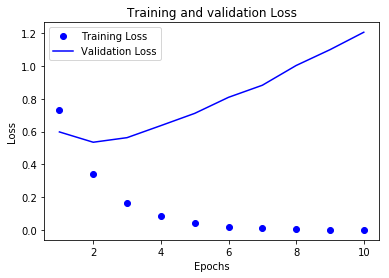

In [40]:
print_loss(history)

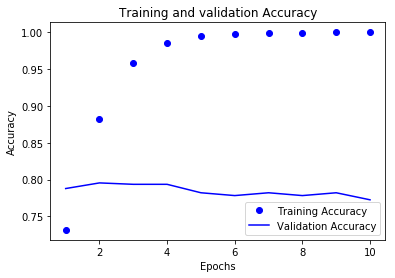

In [41]:
print_acc(history)

In [42]:
# test_loss, test_acc
results = model.evaluate(X_test, y_test)
results

1287/1287 [==============================] - 0s 324us/step


[1.183176350702306, 0.8026418026418026]